In [111]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#You need manually fix data in tox24_alogps_oestate.csv, row 1509

#this is causing errors in standardization

#'C1=CC=[N+](C(=C1)[S-])[O-].C1=CC=[N+](C(=C1)[S-])[O-].[ZnH2+2]' -> 
#'C1=CC=N(=O)C([S-])=C1.C1=CC=N(=O)C([S-])=C1.[Zn+2]'

In [112]:
import pandas as pd
import numpy as np

from src.config import mem
N_JOBS = 40
RANDOM_SEED = 42

df = pd.read_csv('../data/raw/tox24_alogps_oestate.csv')

df.drop(['N'], axis=1, inplace=True)
df.drop_duplicates(inplace=True)

print(df.shape)
df.head()

(1511, 367)


,SMILES,ALogPS_logP,ALogPS_logS,HALOG,MW,N.1,NA,NH,O,P,...,Se1C2N2dd,Se1C2N==sd,SdddN,SdddN(nitro),Se2N3O1d,SddSi,Se2O1Si2d,Se1B3C3sa,Se1N3pO1a,SeaC2N3paa
0,CC1=CC[C@H]2C[C@@H]1C2(C)C,3.66,-2.94,0,136.3,0,10,16,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,CC1(C)[C@@H]2C[C@H]1C(=C)CC2,3.94,-3.33,0,136.3,0,10,16,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,COC(=O)C(C)OC1=CC=C(OC2=CC=C(Cl)C=C2Cl)C=C1,5.13,-5.40,2,341.2,0,22,14,4,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,CC(OC1=C(C)C=C(Cl)C=C1)C(O)=O,2.87,-2.47,1,214.7,0,14,11,3,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,CCCCCCCCCCCCCC(=O)OCC(O)CO,4.77,-4.09,0,302.5,0,21,34,4,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [113]:
train = pd.read_csv('../data/raw/tox24_challenge_train.csv')
train.drop_duplicates(subset='SMILES', inplace=True)

test = pd.read_csv('../data/raw/tox24_challenge_test.csv')

In [114]:
len(test), test.SMILES.isin(df.SMILES).sum()

(500, 500)

In [115]:
len(train), train.SMILES.isin(df.SMILES).sum()

(1011, 1011)

In [116]:
len(test) + len(train), len(df)

(1511, 1511)

In [117]:
features = df.columns.tolist()
features.remove('SMILES')
features

['ALogPS_logP',
 'ALogPS_logS',
 'HALOG',
 'MW',
 'N.1',
 'NA',
 'NH',
 'O',
 'P',
 'PSA',
 'S',
 'SdCH2',
 'SdssC',
 'Se1C1C4s',
 'Se1C2C2ss',
 'Se1C2C3sd',
 'Se1C2C3ss',
 'Se1C3C3ds',
 'Se1C3C4ss',
 'Se2C1C3s',
 'SsCH3',
 'SssCH2',
 'SsssCH',
 'SssssC',
 'aCNOS',
 'ACCEPTORS',
 'RBONDS',
 'SaaCH',
 'SaasC',
 'SdO',
 'SdO(ester)',
 'Se1C1C3s',
 'Se1C1O2s',
 'Se1C3Cl1a',
 'Se1C3O2as',
 'Se1C3O2ds',
 'Se1C3O2ss',
 'Se2C3O1s',
 'SeaC2C2aa',
 'SeaC2C3aa',
 'SeaC3C3aa',
 'SsCl',
 'SssO',
 'SssO(ester)',
 'DONORS',
 'Se1C1C2s',
 'Se1C2O1s',
 'Se1C2O2ss',
 'Se1C3O1s',
 'SsOH',
 'SsOH(alc)',
 'Se1C1C3d',
 'Se1C2C4ss',
 'Se1C4C4ss',
 'SdsCH',
 'Se1C2C2ds',
 'Se2C2C2ss',
 'SdO(keto)',
 'Se1C2C2dd',
 'Se2C2O1s',
 'SaaN',
 'SaasN',
 'Se1C1C3a',
 'Se1C2N3sa',
 'SeaC3N2aa',
 'SeaC3N3aa',
 'SeaN2N3aa',
 'Se1C1C2d',
 'Se1C2C3ds',
 'Se1C3C3ss',
 'Se2C2C3ss',
 'SdO(acid)',
 'Se1C2S2ss',
 'Se1C3N2as',
 'Se1C3O1d',
 'Se1C3S2as',
 'SsOH(acid)',
 'SssNH',
 'SssNH(ar)',
 'SssS',
 'Se1C3C3as',
 'Se1C3Cl1s',


# assign indexes based on smiles

In [118]:
mask = df.SMILES.isin(test.SMILES)
df.loc[mask, 'dataset'] = 'test'

mask = df.SMILES.isin(train.SMILES)
df.loc[mask, 'dataset'] = 'train'

In [119]:
df.dataset.value_counts()

dataset
train    1011
test      500
Name: count, dtype: int64

In [120]:
# test.loc[498, 'SMILES']

In [121]:
# df.loc[1509, 'SMILES']

# Reindex based on smiles

In [122]:
df.set_index('SMILES', inplace=True)
train.set_index('SMILES', inplace=True)
test.set_index('SMILES', inplace=True)

In [123]:
idx = pd.Index(np.concatenate([train.index, test.index]), name='SMILES')
idx.shape

(1511,)

In [124]:
df = df.reindex(idx)

In [125]:
df['target'] = train.activity

In [126]:
df.reset_index(inplace=True)

In [127]:
df.head()

,SMILES,ALogPS_logP,ALogPS_logS,HALOG,MW,N.1,NA,NH,O,P,...,SdddN,SdddN(nitro),Se2N3O1d,SddSi,Se2O1Si2d,Se1B3C3sa,Se1N3pO1a,SeaC2N3paa,dataset,target
0,CC1(C)[C@@H]2C[C@H]1C(=C)CC2,3.94,-3.33,0,136.3,0,10,16,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,train,12.3
1,COC(=O)C(C)OC1=CC=C(OC2=CC=C(Cl)C=C2Cl)C=C1,5.13,-5.40,2,341.2,0,22,14,4,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,train,94.1
2,CCCCCCCCCCCCCC(=O)OCC(O)CO,4.77,-4.09,0,302.5,0,21,34,4,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,train,38.1
3,CC(=O)O[C@@H]1C[C@@H]2CC[C@@]1(C)C2(C)C,3.50,-3.52,0,196.3,0,14,20,2,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,train,11.8
4,CCCCCCCCCC=CCC1CC(=O)OC1=O,5.68,-5.73,0,266.4,0,19,26,3,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,train,98.4


# Basic preprocessing

In [128]:
from src.preprocess import preprocess
from src.utils import smi2mol, mol2smi, get_fps_offset


def prepare_data(df, smi_col='SMILES'):
    df['rdmol'] = df[smi_col].apply(smi2mol)
    df.rdmol = df.rdmol.apply(preprocess)
    df['smi'] = df.rdmol.apply(mol2smi)
    return df

In [129]:
df = mem.cache(prepare_data)(df)

# generate representation: fingerprints, rdkit, mordred descriptors

In [130]:
from src.representation import get_representation_from_series

r = mem.cache(get_representation_from_series, ignore=['n_jobs'])(df.smi, n_jobs=N_JOBS)
r.shape

(1511, 4389)

In [131]:
FPS_OFFSET = get_fps_offset(r.columns)
fps_cols = list(range(FPS_OFFSET))

In [132]:
r.dropna(axis=1, inplace=True)
r.shape

(1511, 3280)

In [133]:
mask = (r.iloc[:, FPS_OFFSET:] == 0).all()
zero_cols = r.iloc[:, FPS_OFFSET:].columns[mask]
r.drop(columns=zero_cols, inplace=True)
r.shape

(1511, 3152)

In [134]:
df = pd.concat([df, r], axis=1)
df.shape

(1511, 3523)

In [135]:
rd_cols = [c for c in df.columns if 'rd_' in str(c)]
md_cols = [c for c in df.columns if 'md_' in str(c)]

In [136]:
# drop nans and constants

# Split train test

In [137]:
train = df.query("dataset == 'train'")[fps_cols + rd_cols + md_cols + features]
y_train = df.query("dataset == 'train'").target

test = df.query("dataset == 'test'")[fps_cols + rd_cols + md_cols + features]

train.shape, test.shape

((1011, 3518), (500, 3518))

In [138]:
train.to_csv('../data/processed/X_train.csv', index=False)
test.to_csv('../data/processed/X_test.csv', index=False)
y_train.to_csv('../data/processed/y_train.csv', index=False)

# Model training

In [43]:
import time

import numpy as np
import pandas as pd

from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn.cross_decomposition import PLSRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score, KFold
from sklearn.preprocessing import StandardScaler

from src.utils import OffsetScaler, get_fps_offset
import xgboost as xgb
from catboost import CatBoostRegressor
import seaborn as sns


mae = 'neg_mean_absolute_error'
mse = 'neg_mean_squared_error'
rmse = 'neg_root_mean_squared_error'


# prepare models
models = {}

# models['LR'] = LinearRegression()
# models['Ridge'] = Ridge()
models['PLS'] = PLSRegression()
models['DT'] = DecisionTreeRegressor(random_state=RANDOM_SEED)
models['Lasso'] = Lasso()
models['KNN'] = KNeighborsRegressor(n_jobs=N_JOBS)
models['SVR'] = SVR()
models['RF'] = RandomForestRegressor(random_state=RANDOM_SEED, n_jobs=N_JOBS)
models['XGB'] = xgb.XGBRegressor(random_state=RANDOM_SEED, n_jobs=N_JOBS, verbosity=0)
models['CATB'] = CatBoostRegressor(loss_function='RMSE', verbose=False, random_seed=RANDOM_SEED, thread_count=N_JOBS)
# models['CATB GPU'] = CatBoostRegressor(loss_function='RMSE', verbose=False, random_seed=RANDOM_SEED, thread_count=N_JOBS, task_type='GPU')

scaler = OffsetScaler(offset=FPS_OFFSET)
ss = StandardScaler()

In [29]:
def evaluate(X):
    results = {}

    for name in models.keys():
        tic = time.time()
        
        model = models[name]
        kfold = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
        results[name] = cross_val_score(model, X, y_train, cv=kfold, scoring=rmse)
        
        toc = time.time()
        mean = results[name].mean()
        std = results[name].std()
        final_score = mean - std
        print("%5s: %3.3f     %3.3f ± %3.3f      %.1fs" % (name, final_score, mean, std, toc - tic))
        
    return pd.DataFrame(results)

# Full Features + FPS

  PLS: -30.213     -29.369 ± 0.844      0.4s
   DT: -37.060     -33.885 ± 3.175      3.5s
Lasso: -28.380     -27.472 ± 0.908      1.9s
  KNN: -29.797     -27.694 ± 2.103      0.3s
  SVR: -35.665     -34.691 ± 0.974      6.7s
   RF: -25.853     -24.100 ± 1.753      9.7s
  XGB: -26.472     -24.798 ± 1.675      14.4s
 CATB: -25.142     -23.736 ± 1.407      215.0s


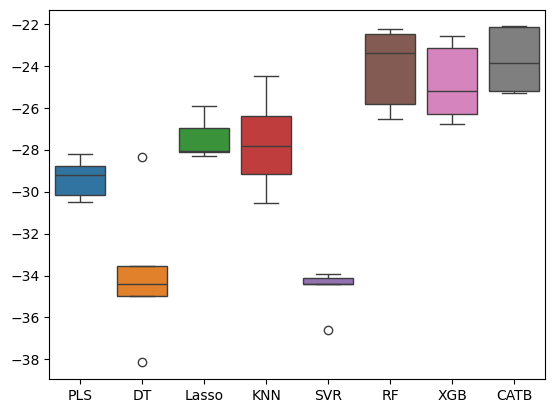

In [32]:
X_train = train[fps_cols + rd_cols + md_cols + features]

X_train_scale = scaler.fit_transform(X_train.values)

results = evaluate(X_train_scale)

sns.boxplot(results);

In [33]:
X_train = train[fps_cols + rd_cols + features]
X_train_scale = scaler.fit_transform(X_train.values)

results = evaluate(X_train_scale)

  PLS: -30.350     -29.108 ± 1.243      0.3s
   DT: -34.965     -33.371 ± 1.594      1.5s
Lasso: -28.716     -27.808 ± 0.908      1.2s
  KNN: -30.315     -28.392 ± 1.924      0.2s
  SVR: -36.329     -35.362 ± 0.967      5.5s
   RF: -25.795     -24.027 ± 1.768      5.3s
  XGB: -27.322     -25.314 ± 2.008      5.4s
 CATB: -25.185     -23.651 ± 1.534      89.2s


In [34]:
X_train = train[fps_cols + md_cols + features]
X_train_scale = scaler.fit_transform(X_train.values)

results = evaluate(X_train_scale)

  PLS: -30.359     -29.470 ± 0.889      0.3s
   DT: -38.272     -35.783 ± 2.489      2.8s
Lasso: -28.409     -27.510 ± 0.899      2.3s
  KNN: -29.663     -27.813 ± 1.850      0.2s
  SVR: -35.779     -34.810 ± 0.969      6.5s
   RF: -25.794     -24.116 ± 1.678      8.9s
  XGB: -27.073     -25.418 ± 1.656      10.0s
 CATB: -25.032     -23.786 ± 1.246      119.5s


In [35]:
X_train = train[fps_cols + features]
X_train_scale = scaler.fit_transform(X_train.values)

results = evaluate(X_train_scale)

  PLS: -31.679     -29.643 ± 2.036      0.3s
   DT: -34.511     -32.456 ± 2.056      1.5s
Lasso: -29.767     -28.465 ± 1.303      2.9s
  KNN: -30.857     -29.188 ± 1.669      0.2s
  SVR: -36.971     -35.992 ± 0.979      5.5s
   RF: -25.646     -24.005 ± 1.641      4.3s
  XGB: -26.754     -25.252 ± 1.502      4.0s
 CATB: -25.289     -23.924 ± 1.364      103.7s


# Features only

In [36]:
from sklearn.preprocessing import StandardScaler

X_train = train[features]
X_train_scale = ss.fit_transform(X_train.values)

results = evaluate(X_train_scale)

  PLS: -36.398     -32.218 ± 4.180      0.0s
   DT: -34.366     -33.118 ± 1.247      0.3s
Lasso: -39.616     -32.984 ± 6.633      0.3s
  KNN: -31.812     -30.134 ± 1.678      0.1s
  SVR: -37.199     -36.169 ± 1.030      0.8s
   RF: -26.444     -24.600 ± 1.845      1.6s
  XGB: -27.463     -25.904 ± 1.559      1.4s
 CATB: -26.437     -24.556 ± 1.881      18.1s


In [37]:
from sklearn.preprocessing import StandardScaler

X_train = train[rd_cols + md_cols + features]
X_train_scale = ss.fit_transform(X_train.values)

results = evaluate(X_train_scale)

  PLS: -32.637     -31.166 ± 1.471      0.1s
   DT: -36.768     -34.454 ± 2.314      2.2s
Lasso: -32.811     -29.253 ± 3.559      0.8s
  KNN: -30.027     -28.287 ± 1.740      0.1s
  SVR: -35.552     -34.508 ± 1.044      2.1s
   RF: -26.039     -24.530 ± 1.509      7.3s
  XGB: -26.684     -25.028 ± 1.656      7.3s
 CATB: -25.281     -23.617 ± 1.664      60.3s


# RandomForest finetune

In [38]:
models['RF 100'] = RandomForestRegressor(n_estimators=100, random_state=RANDOM_SEED, n_jobs=N_JOBS)
models['RF 200'] = RandomForestRegressor(n_estimators=200, random_state=RANDOM_SEED, n_jobs=N_JOBS)
models['RF 400'] = RandomForestRegressor(n_estimators=400, random_state=RANDOM_SEED, n_jobs=N_JOBS)
models['RF 800'] = RandomForestRegressor(n_estimators=800, random_state=RANDOM_SEED, n_jobs=N_JOBS)

RF 100: -24.005 ± 1.641    4.5s
RF 200: -23.982 ± 1.709    7.7s
RF 400: -23.872 ± 1.781    12.8s
RF 800: -23.923 ± 1.816    24.5s
 CATB: -23.924 ± 1.364    98.5s


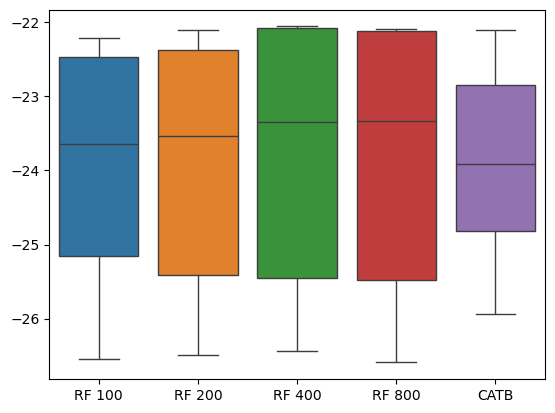

In [39]:
X_train = train[fps_cols + features]
X_train_scale = scaler.fit_transform(X_train.values)

results = {}

for name in ['RF 100', 'RF 200', 'RF 400', 'RF 800', 'CATB']:
    tic = time.time()
    
    model = models[name]
    kfold = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
    results[name] = cross_val_score(model, X_train_scale, y_train, cv=kfold, scoring=rmse)
    
    toc = time.time()    
    print("%5s: %3.3f ± %3.3f    %.1fs" % (name, results[name].mean(), results[name].std(), toc - tic))
    
results = pd.DataFrame(results)
sns.boxplot(results);

# Correlations

In [494]:
train.shape

(1011, 3518)

In [495]:
full_feats = train[rd_cols + md_cols + features]

feats_target = pd.concat([full_feats, y_train], axis=1)
feats_target.shape

(1011, 1156)

In [496]:
full_feats.isna().sum().sum()

0

In [497]:
cols_to_drop = [col for col in feats_target.columns if feats_target[col].nunique() == 1]

print(len(cols_to_drop))

# Drop those columns
feats_target.drop(columns=cols_to_drop, inplace=True)
feats_target.shape

38


(1011, 1118)

In [498]:
corr = mem.cache(lambda x: x.corr())(feats_target)

________________________________________________________________________________
[Memory] Calling __main__--tmp-ipykernel-779951703.<lambda>...
<lambda>(       rd_BalabanJ   rd_BertzCT    rd_Chi0   rd_Chi0n   rd_Chi0v    rd_Chi1  \
0     2.231081e+00   174.477332   7.353371   6.983128   6.983128   4.621027   
1     2.039717e+00   655.695424  16.112520  12.007724  13.519582  10.490402   
2     3.158254e+00   230.829998  15.761302  13.687769  13.687769  10.201907   
3     2.225540e+00   269.495295  10.560478   9.592517   9.592517   6.376846   
4     2.002792e+00   366.070992  13.924439  11.898687  11.898687   9.236382   
...            ...          ...        ...        ...        ...        ...   
1006  1.547850e+00   726.837791  19.225404  16.027681  16.027681  13.117724   
1007  2.258072e+00   909.550973  16.396977  12.652568  12.652568  11...)
_________________________________________________________<lambda> - 1.6s, 0.0min


In [499]:
corr.shape

(1118, 1118)

In [500]:
from src.corr import noncorrelated_features

ids = noncorrelated_features(corr, threshold=0.95)

corr.columns[ids]

Index(['rd_EState_VSA1', 'rd_EState_VSA10', 'rd_EState_VSA11',
       'rd_EState_VSA2', 'rd_EState_VSA7', 'rd_FpDensityMorgan1',
       'rd_FpDensityMorgan2', 'rd_FpDensityMorgan3', 'rd_HallKierAlpha',
       'rd_Ipc',
       ...
       'Se1O1Cl2d', 'Se1C2F1s', 'SssssBH', 'Se1C2Cl1d', 'Se1C4N1s', 'Se1C4S1s',
       'SeaN2NHaa', 'Se1C3P4sd', 'Se1C3Br1s', 'Se2N3O1a'],
      dtype='object', length=658)

In [501]:
corr.iloc[ids, -1].abs().sort_values(ascending=False)

rd_fr_benzene    0.382289
SeaC2C3aa        0.379202
md_piPC7         0.366857
md_NaasC         0.364692
md_piPC2         0.359232
                   ...   
Se1C3S2ss        0.000518
Se1C2S2ds        0.000482
Se1O1P4d         0.000471
md_ECIndex       0.000297
rd_fr_hdrzine    0.000141
Name: target, Length: 658, dtype: float64

In [503]:
uncorr_feats = corr.columns[ids].tolist()

In [504]:
uncorr_feats

['rd_EState_VSA1',
 'rd_EState_VSA10',
 'rd_EState_VSA11',
 'rd_EState_VSA2',
 'rd_EState_VSA7',
 'rd_FpDensityMorgan1',
 'rd_FpDensityMorgan2',
 'rd_FpDensityMorgan3',
 'rd_HallKierAlpha',
 'rd_Ipc',
 'rd_Kappa1',
 'rd_Kappa2',
 'rd_Kappa3',
 'rd_MaxEStateIndex',
 'rd_MinAbsEStateIndex',
 'rd_MinEStateIndex',
 'rd_MolLogP',
 'rd_NOCount',
 'rd_NumAliphaticCarbocycles',
 'rd_NumAliphaticHeterocycles',
 'rd_NumAliphaticRings',
 'rd_NumAromaticHeterocycles',
 'rd_NumHAcceptors',
 'rd_NumHeteroatoms',
 'rd_NumRadicalElectrons',
 'rd_NumSaturatedCarbocycles',
 'rd_NumSaturatedHeterocycles',
 'rd_NumSaturatedRings',
 'rd_PEOE_VSA1',
 'rd_PEOE_VSA10',
 'rd_PEOE_VSA14',
 'rd_PEOE_VSA2',
 'rd_PEOE_VSA3',
 'rd_PEOE_VSA4',
 'rd_PEOE_VSA5',
 'rd_PEOE_VSA8',
 'rd_PEOE_VSA9',
 'rd_RingCount',
 'rd_SMR_VSA10',
 'rd_SlogP_VSA10',
 'rd_SlogP_VSA12',
 'rd_SlogP_VSA3',
 'rd_SlogP_VSA4',
 'rd_SlogP_VSA5',
 'rd_SlogP_VSA7',
 'rd_VSA_EState10',
 'rd_VSA_EState2',
 'rd_VSA_EState3',
 'rd_VSA_EState4',
 'rd_

  PLS: -30.342     -29.136 ± 1.206      0.3s
   DT: -36.706     -34.883 ± 1.823      2.5s
Lasso: -28.393     -27.522 ± 0.871      1.1s
  KNN: -29.130     -27.582 ± 1.548      0.2s
  SVR: -36.193     -35.180 ± 1.013      5.9s
   RF: -25.701     -24.275 ± 1.426      6.7s
  XGB: -27.325     -25.326 ± 1.999      7.9s
 CATB: -24.968     -23.640 ± 1.327      102.0s
RF 100: -25.701     -24.275 ± 1.426      7.2s
RF 200: -25.721     -24.140 ± 1.581      11.0s
RF 400: -25.691     -24.120 ± 1.571      20.3s
RF 800: -25.683     -24.110 ± 1.572      40.8s


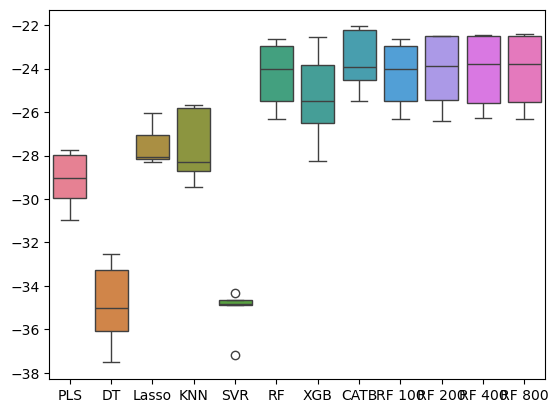

In [102]:
X_train = train[fps_cols + uncorr_feats]
X_train_scale = scaler.fit_transform(X_train.values)
results = evaluate(X_train_scale)

In [55]:
fi_train = train[fps_cols + uncorr_feats]
fi_train_scale = scaler.fit_transform(fi_train.values)
clf = CatBoostRegressor(random_seed=RANDOM_SEED, verbose=False).fit(fi_train_scale, y_train)

In [46]:
def top_k_feats(model, X, k):
    fi = pd.Series(model.get_feature_importance(), index=X.columns, name='importance')
    return fi[FPS_OFFSET:].sort_values(ascending=False)[:k].index.tolist()

In [56]:
top_100_feats = top_k_feats(clf, fi_train, 100)
top_100_feats

['rd_MolLogP',
 'md_FilterItLogS',
 'md_SMR_VSA9',
 'ALogPS_logP',
 'ALogPS_logS',
 'md_SlogP_VSA11',
 'md_AATS0v',
 'md_ATSC1i',
 'md_BertzCT',
 'SsOH(phen)',
 'md_ATSC1pe',
 'md_NaasC',
 'md_piPC2',
 'md_ATS8dv',
 'md_Mv',
 'md_ATSC1p',
 'rd_NOCount',
 'MW',
 'md_JGI6',
 'md_SsOH',
 'md_ATSC3Z',
 'md_AATS0i',
 'md_ATSC1m',
 'md_nBondsKD',
 'md_ATSC1v',
 'md_PEOE_VSA6',
 'md_SMR_VSA3',
 'md_CIC5',
 'md_NsssCH',
 'rd_VSA_EState5',
 'rd_VSA_EState8',
 'md_JGI7',
 'md_ATS8i',
 'rd_NumHAcceptors',
 'rd_VSA_EState9',
 'md_ATSC8m',
 'rd_VSA_EState3',
 'md_nHBDon',
 'Se1C2C3sd',
 'md_nAcid',
 'md_MIC5',
 'md_ATSC3i',
 'SdO(amid)',
 'rd_NumAliphaticHeterocycles',
 'md_JGI8',
 'md_IC5',
 'SeaC3C3aa',
 'md_ATSC5pe',
 'md_nS',
 'md_SMR_VSA4',
 'rd_MaxEStateIndex',
 'md_ATSC8dv',
 'md_GGI6',
 'md_fragCpx',
 'md_ATSC7v',
 'md_ATSC3pe',
 'md_CIC0',
 'md_Mpe',
 'md_ATSC5dv',
 'md_nBase',
 'md_ATSC2i',
 'Se1C2C3ss',
 'Se2C3O1s',
 'md_Mp',
 'rd_MinAbsEStateIndex',
 'rd_FpDensityMorgan3',
 'md_EState_V

In [48]:
X_train = train[fps_cols + top_100_feats]

X_train_scale = scaler.fit_transform(X_train.values)

results = evaluate(X_train_scale)

  PLS: -30.628     -29.237 ± 1.391      0.3s
   DT: -35.555     -33.026 ± 2.529      1.6s
Lasso: -29.192     -28.140 ± 1.052      1.0s
  KNN: -28.096     -26.584 ± 1.512      0.3s
  SVR: -35.125     -34.381 ± 0.743      4.9s
   RF: -25.504     -23.908 ± 1.595      4.5s
  XGB: -25.945     -24.440 ± 1.505      5.5s
 CATB: -24.848     -23.489 ± 1.359      98.8s


In [57]:
top_50_feats = top_k_feats(clf, fi_train, 50)

X_train = train[fps_cols + top_50_feats]
X_train_scale = scaler.fit_transform(X_train.values)

results = evaluate(X_train_scale)

  PLS: -30.922     -29.249 ± 1.673      0.2s
   DT: -33.612     -32.761 ± 0.851      1.4s
Lasso: -29.341     -28.264 ± 1.077      1.1s
  KNN: -29.000     -27.593 ± 1.407      0.2s
  SVR: -35.017     -34.298 ± 0.718      4.6s
   RF: -25.285     -23.430 ± 1.855      4.1s
  XGB: -26.681     -24.882 ± 1.799      3.9s
 CATB: -24.281     -22.882 ± 1.399      87.5s


In [60]:
top_20_feats = top_k_feats(clf, fi_train, 20)

X_train = train[fps_cols + top_20_feats]
X_train_scale = scaler.fit_transform(X_train.values)

results = evaluate(X_train_scale)

  PLS: -31.205     -29.470 ± 1.735      0.3s
   DT: -37.249     -34.715 ± 2.534      1.3s
Lasso: -30.745     -29.218 ± 1.526      0.9s
  KNN: -29.240     -27.794 ± 1.446      0.2s
  SVR: -35.425     -34.710 ± 0.715      4.6s
   RF: -25.522     -23.504 ± 2.018      3.8s
  XGB: -25.884     -23.837 ± 2.047      3.4s
 CATB: -24.724     -23.161 ± 1.563      79.9s


In [66]:
top_50_feats

['rd_MolLogP',
 'md_FilterItLogS',
 'md_SMR_VSA9',
 'ALogPS_logP',
 'ALogPS_logS',
 'md_SlogP_VSA11',
 'md_AATS0v',
 'md_ATSC1i',
 'md_BertzCT',
 'SsOH(phen)',
 'md_ATSC1pe',
 'md_NaasC',
 'md_piPC2',
 'md_ATS8dv',
 'md_Mv',
 'md_ATSC1p',
 'rd_NOCount',
 'MW',
 'md_JGI6',
 'md_SsOH',
 'md_ATSC3Z',
 'md_AATS0i',
 'md_ATSC1m',
 'md_nBondsKD',
 'md_ATSC1v',
 'md_PEOE_VSA6',
 'md_SMR_VSA3',
 'md_CIC5',
 'md_NsssCH',
 'rd_VSA_EState5',
 'rd_VSA_EState8',
 'md_JGI7',
 'md_ATS8i',
 'rd_NumHAcceptors',
 'rd_VSA_EState9',
 'md_ATSC8m',
 'rd_VSA_EState3',
 'md_nHBDon',
 'Se1C2C3sd',
 'md_nAcid',
 'md_MIC5',
 'md_ATSC3i',
 'SdO(amid)',
 'rd_NumAliphaticHeterocycles',
 'md_JGI8',
 'md_IC5',
 'SeaC3C3aa',
 'md_ATSC5pe',
 'md_nS',
 'md_SMR_VSA4']

In [61]:
X_train = train[fps_cols + top_50_feats]
X_train_scale = scaler.fit_transform(X_train.values)

models['CATB'].fit(X_train_scale, y_train)

X_test = test[fps_cols + top_50_feats]
X_test_scale = scaler.transform(X_test.values)
y_pred = models['CATB'].predict(X_test_scale)

In [65]:
pd.Series(y_pred, name='Results').to_csv('fps_top_50_feats_catboost.csv', index=False)